In [2]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import *
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new

In [3]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 6.5
one_column = 3.2
twothird_column = 5.5
mpl.rcParams['figure.figsize'] = [two_column, two_column]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

In [4]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [5]:
def get_OSG_point_percentiles(DATE, percentile=50):
    variable = var.replace(':', '_').replace(' ', '_')
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    
    with h5py.File(DIR+FILE, 'r') as f:
        per_value = f["p%02d" % percentile][x][y]
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        per_value -= 273.15
    
    return per_value

In [6]:
def get_OSG_percentiles(DATE, percentile=50):
    variable = var.replace(':', '_').replace(' ', '_')
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    
    with h5py.File(DIR+FILE, 'r') as f:
        per_value = f["p%02d" % percentile][:]
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        per_value -= 273.15
    
    return per_value

In [7]:
percentiles = [0, 1, 2, 3, 4, 5, 10, 25, 33, 50, 66, 75, 90, 95, 96, 97, 98, 99, 100]
var = 'UVGRD:10 m'

# Date of interest
leapyear = 2016
DATE = datetime(leapyear, 10, 9, 6)

In [8]:
if var == 'TMP:2 m':
    MWvar = 'air_temp'
    label = '2 m Temperature'
    units = 'C'
    cmap = 'bwr'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
    label = '2 m Dew Point Temperature'
    units = 'C'
    cmap = 'BrBG'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
    label = '10 m Wind Speed'
    units = r'm s$\mathregular{^{-1}}$'
    cmap = 'PiYG'
elif var == 'UVGRD:80 m':
    MWvar = 'wind_speed'
    label = '80 m Wind Speed'
    units = r'm s$\mathregular{^{-1}}$'
    cmap = 'PRGn'
else:
    MWvar = ''
    label = 'unknown'
    units = 'unknown'
    cmap = 'viridis'
    print "NO MATCHING VAR AND MESOWEST VAR"

## Validation for Single Location

In [9]:
stn = 'WBB'
p = 50

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

In [10]:
# Get Percentile from OSG dataset
HR_per = get_OSG_point_percentiles(DATE, percentile=p)

In [11]:
# Get percentile from MesoWest dataset
start = DATE.strftime('%m%d%H')
end = start

a = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles=[p])
MW_per = a['p%02d' % p][0]

In [12]:
print '%sth Percentile' % p
print '      HRRR:\t', HR_per
print '  MesoWest:\t', MW_per

50th Percentile
      HRRR:	3.183
  MesoWest:	2.06


In [13]:
# Create Map Object
m = Basemap(projection='cyl',
            llcrnrlon=MWlon-.3,  urcrnrlon=MWlon+.3,
            llcrnrlat=MWlat-.3, urcrnrlat=MWlat+.3)

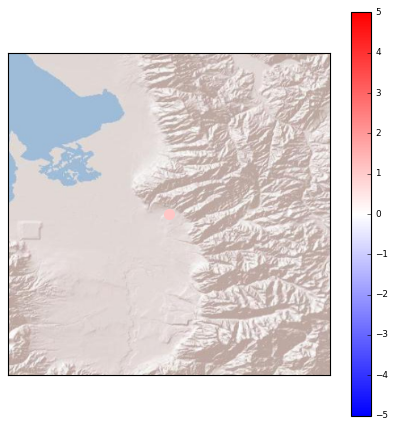

In [14]:
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.scatter(MWlon, MWlat,
          c=np.mean(HR_per-MW_per),
          linewidth=0,
          s=100,
          cmap='bwr',
          vmin=-5, vmax=5)
plt.colorbar()

## Validate Utah NWS and RAWS stations

In [15]:
# Percentile of interest
p=50

In [16]:
m = draw_Utah_map()

In [17]:
from BB_MesoWest.get_token import my_token
import json

token = my_token()
URL = 'http://api.mesowest.net/v2/stations/metadata?&token=' + token + '&state=UT&network=1,2'
f = urllib2.urlopen(URL)
data_UT = f.read()
data_UT = json.loads(data_UT)

In [18]:
num = int(len(data_UT['STATION']))
print 'Number of Stations: %.f' % num

Number of Stations: 162


In [20]:
start = DATE.strftime('%m%d%H')
end = start

for i, s in enumerate(data_UT['STATION']):
    print '\r>> %.2f%% complete. Working on %s' % (i/float(num)*100, s['STID']),
    sys.stdout.flush()
    
    try:
        # MesoWest percentile
        a = get_mesowest_percentiles(s['STID'], variable=MWvar, start=start, end=end, percentiles=[p])
        MW_per = a['p%02d' % p][0]
        s['MW_per'] = MW_per

        # HRRR percentile
        MWlat = float(s['LATITUDE'])
        MWlon = float(s['LONGITUDE'])
        point = pluck_point_new(MWlat, MWlon, lat, lon)
        x = point[0][0]
        y = point[1][0]
        HR_per = get_OSG_point_percentiles(DATE, percentile=p)
        s['HR_per'] = HR_per
    except:
        pass
        
print '\r>> Data retrieval 100% complete.',

>> 9.88% complete. Working on KDPG DID NOT WORK: http://api.synopticlabs.org/v2/percentiles?&token=2562b729557f45f5958516081f06c9eb&start=100906&end=100906&vars=wind_speed&stid=KDPG&percentiles=50&psource=PERCENTILES2
>> 12.35% complete. Working on KT62 DID NOT WORK: http://api.synopticlabs.org/v2/percentiles?&token=2562b729557f45f5958516081f06c9eb&start=100906&end=100906&vars=wind_speed&stid=KT62&percentiles=50&psource=PERCENTILES2
>> 12.96% complete. Working on KU17 DID NOT WORK: http://api.synopticlabs.org/v2/percentiles?&token=2562b729557f45f5958516081f06c9eb&start=100906&end=100906&vars=wind_speed&stid=KU17&percentiles=50&psource=PERCENTILES2
>> 14.20% complete. Working on KU28 DID NOT WORK: http://api.synopticlabs.org/v2/percentiles?&token=2562b729557f45f5958516081f06c9eb&start=100906&end=100906&vars=wind_speed&stid=KU28&percentiles=50&psource=PERCENTILES2
>> 14.81% complete. Working on PARV DID NOT WORK: http://api.synopticlabs.org/v2/percentiles?&token=2562b729557f45f5958516081

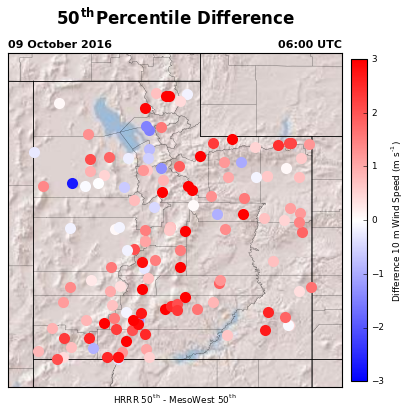

In [22]:
# plot difference
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.drawstates()
m.drawcounties()
for s in data_UT['STATION']:
    if 'HR_per' in s:
        m.scatter(float(s['LONGITUDE']), float(s['LATITUDE']),
                  latlon=True,
                  c=np.mean(s['HR_per']-s['MW_per']),
                  linewidth=0,
                  s=100,
                  cmap='bwr',
                  vmin=-3, vmax=3,
                  zorder=10)
cb = plt.colorbar(pad=.02, shrink=.8)
cb.set_label('Difference %s (%s)' % (label, units))
cb.set_ticks([range(-3,4)])

plt.title(r'%s$\mathregular{^{th}}$' % p + 'Percentile Difference\n', fontweight='semibold', fontsize=15)
plt.title(DATE.strftime('%d %B %Y'), fontweight='semibold', loc='left')
plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')
plt.xlabel(r'HRRR %s$\mathregular{^{th}}$ - MesoWest %s$\mathregular{^{th}}$' % (p,p))

## Validate HWKC1 NWS and RAWS stations

In [157]:
# Percentile of interest
p=95

In [158]:
from BB_MesoWest.get_token import my_token
import json

token = my_token()
URL = 'http://api.mesowest.net/v2/stations/metadata?&token=' + token + '&radius=HWKC1,200'
if False:
    URL += '&network=1,2'
f = urllib2.urlopen(URL)
data_CA = f.read()
data_CA = json.loads(data_CA)

In [159]:
num = int(len(data_CA['STATION']))
print 'Number of Stations: %.f' % num

Number of Stations: 2933


In [160]:
for s in data_CA['STATION']:
    if s['STID'] == 'HWKC1':
        MWlon = float(s['LONGITUDE'])
        MWlat = float(s['LATITUDE'])
# Create Map Object
m = Basemap(projection='cyl',
            llcrnrlon=MWlon-2,  urcrnrlon=MWlon+2,
            llcrnrlat=MWlat-2, urcrnrlat=MWlat+2)

In [1]:
start = DATE.strftime('%m%d%H')
end = start

for i, s in enumerate(data_CA['STATION']):
    print '\r>> %.2f%% complete. Working on %s' % (i/float(num)*100, s['STID']),
    sys.stdout.flush()
    
    # MesoWest percentile
    a = get_mesowest_percentiles(s['STID'], variable=MWvar, start=start, end=end, percentiles=[p])
    if a['years'] >= 3:
        MW_per = a['p%02d' % p][0]
        s['MW_per'] = MW_per

        # HRRR percentile
        MWlat = float(s['LATITUDE'])
        MWlon = float(s['LONGITUDE'])
        point = pluck_point_new(MWlat, MWlon, lat, lon)
        x = point[0][0]
        y = point[1][0]

        HR_per = get_OSG_point_percentiles(DATE, percentile=p)
        s['HR_per'] = HR_per
print '\r>> Data retrieval 100% complete.',

NameError: name 'DATE' is not defined

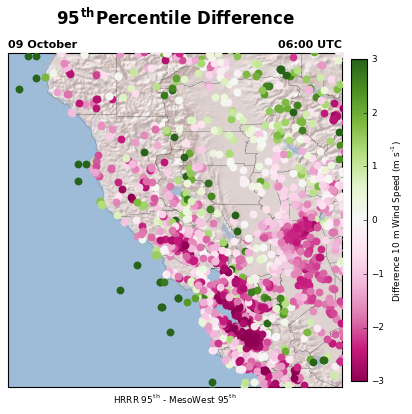

In [162]:
# plot difference
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.drawstates()
m.drawcounties()
for s in data_CA['STATION']:
    m.scatter(float(s['LONGITUDE']), float(s['LATITUDE']),
              latlon=True,
              c=np.mean(s['HR_per']-s['MW_per']),
              linewidth=0,
              s=50,
              cmap=cmap,
              vmin=-3, vmax=3,
              zorder=10)
cb = plt.colorbar(pad=.02, shrink=.8)
cb.set_label('Difference %s (%s)' % (label, units))
cb.set_ticks([range(-3,4)])

plt.title(r'%s$\mathregular{^{th}}$' % p + 'Percentile Difference\n', fontweight='semibold', fontsize=15)
plt.title(DATE.strftime('%d %B'), fontweight='semibold', loc='left')
plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')
plt.xlabel(r'HRRR %s$\mathregular{^{th}}$ - MesoWest %s$\mathregular{^{th}}$' % (p,p))

In [163]:
# HRRR at time of interest
Hu = get_hrrr_variable(datetime(2017, 10, 9, 6), 'UGRD:10 m', verbose=False)
Hv = get_hrrr_variable(datetime(2017, 10, 9, 6), 'VGRD:10 m', verbose=False)
H = Hu.copy()
H['value'] = wind_uv_to_spd(Hu['value'], Hv['value'])

In [164]:
# HRRR 95th percentile
p95 = get_OSG_percentiles(DATE, percentile=95)

In [165]:
DATE

datetime.datetime(2016, 10, 9, 6, 0)

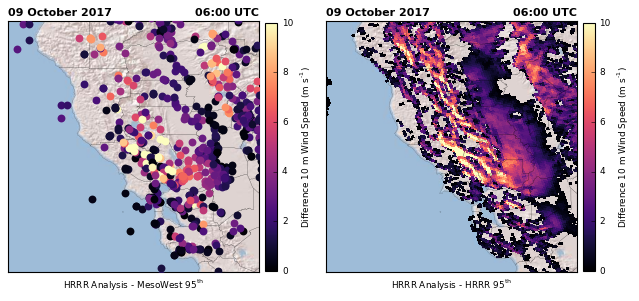

In [172]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])

plt.sca(ax1)
# plot difference
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.drawstates()
m.drawcounties()
for s in data_CA['STATION']:
    # HRRR percentile
    MWlat = float(s['LATITUDE'])
    MWlon = float(s['LONGITUDE'])
    point = pluck_point_new(MWlat, MWlon, lat, lon)
    x = point[0][0]
    y = point[1][0]
    Hpoint = H['value'][x][y]
    
    if Hpoint-s['MW_per'] > 0:
        # only plot stations where HRRR analysis is greater than station 95th
        m.scatter(float(s['LONGITUDE']), float(s['LATITUDE']),
                  latlon=True,
                  c=Hpoint-s['MW_per'],
                  linewidth=0,
                  s=50,
                  cmap='magma',
                  vmin=0, vmax=10,
                  zorder=10)
cb = plt.colorbar(pad=.02, shrink=.8)
cb.set_label('Difference %s (%s)' % (label, units))
cb.set_ticks([range(0,11,2)])

plt.title(DATE.strftime('%d %B 2017'), fontweight='semibold', loc='left')
plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')
plt.xlabel(r'HRRR Analysis - MesoWest %s$\mathregular{^{th}}$' % (p))

plt.sca(ax2)
# plot difference
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.drawstates()
m.drawcounties()


masked = H['value']-p95
masked = np.ma.array(masked)
masked[masked < 0] = np.ma.masked

m.pcolormesh(lon, lat, masked,
             vmax=10, vmin=0,
             cmap='magma')

cb = plt.colorbar(pad=.02, shrink=.8)
cb.set_label('Difference %s (%s)' % (label, units))
cb.set_ticks([range(0,11,2)])

plt.title(DATE.strftime('%d %B 2017'), fontweight='semibold', loc='left')
plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')
plt.xlabel(r'HRRR Analysis - HRRR %s$\mathregular{^{th}}$' % (p))

## CONUS NWS stations

In [173]:
m = draw_CONUS_cyl_map()

In [174]:
from BB_MesoWest.get_token import my_token
import json
import time, sys

token = my_token()
URL = 'http://api.mesowest.net/v2/stations/metadata?&token=' + token + '&network=1'
f = urllib2.urlopen(URL)
data = f.read()
data = json.loads(data)

In [175]:
num = float(len(data['STATION']))
print 'Number of Stations: %.f' % num

Number of Stations: 3334


In [185]:
DATE_CONUS = datetime(2016, 3, 15)

start = DATE_CONUS.strftime('%m%d%H')
end = start

for i, s in enumerate(data['STATION']):
    try:
        print '\r>> %.2f%% complete. Working on %s' % (i/num*100, s['STID']),
        sys.stdout.flush()
    except:
        pass

    # MesoWest EPD
    MW_per = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles=[50])
    if MW_per['years'] >= 3:
        s['MW_per'] = MW_per['p50'][0]

        # HRRR EPD
        MWlat = float(s['LATITUDE'])
        MWlon = float(s['LONGITUDE'])
        point = pluck_point_new(MWlat, MWlon, lat, lon)
        x = point[0][0]
        y = point[1][0]

        HR_per = get_OSG_point_percentiles(DATE_CONUS, percentile=50)
        s['HR_per'] = HR_per
print '\r>> Data retrieval 100% complete.',

>> Data retrieval 100% complete.


In [187]:
s

{u'ELEVATION': u'614',
 u'ELEV_DEM': None,
 'HR_per': 2.04,
 u'ID': u'64524',
 u'LATITUDE': u'35.87866',
 u'LONGITUDE': u'-86.37749',
 u'MNET_ID': u'1',
 'MW_per': 2.98,
 u'NAME': u'Murfreesboro Municipal Airport',
 u'PERIOD_OF_RECORD': {u'end': None, u'start': None},
 u'RESTRICTED': False,
 u'STATE': u'TN',
 u'STATUS': u'ACTIVE',
 u'STID': u'KMBT',
 u'TIMEZONE': u'America/Chicago'}

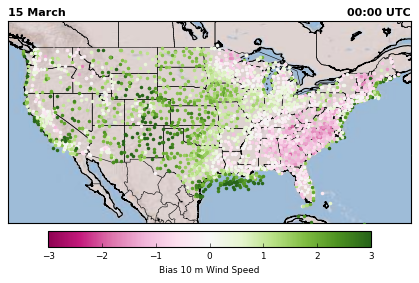

In [189]:
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.drawstates()
m.drawcoastlines()
m.drawcountries()
for s in data['STATION']:
    m.scatter(float(s['LONGITUDE']), float(s['LATITUDE']),
              latlon=True,
              c=s['HR_per']-s['MW_per'],
              linewidth=0,
              s=10,
              cmap='PiYG',
              vmin=-3, vmax=3,
              zorder=10)
cb = plt.colorbar(pad=.02, shrink=.8, orientation='horizontal')
cb.set_label('Bias ' + label)
cb.set_ticks([range(-3,4)])

plt.title(DATE_CONUS.strftime('%d %B'), fontweight='semibold', loc='left')
plt.title(DATE_CONUS.strftime('%H:%M UTC'), fontweight='semibold', loc='right')